# 3D Ultrasound Defect Analysis

## Project Overview
This notebook demonstrates a simplified, end-to-end workflow for analyzing and visualizing defects detected in ultrasound imaging data.

Using a publicly available 3D ultrasound dataset, we:
- Load slice-based ultrasound volumes
- Identify defect regions using provided segmentation masks
- Extract quantitative defect metrics (area, centroid, bounding box)
- Construct a 3D visualization that shows defect size, location, and progression across slices

The goal is to replicate, at a small scale, the type of analysis and visualization used in industrial non-destructive testing (NDT) and pipeline inspection workflows.

Data source: https://data.mendeley.com/datasets/w3cmdx9sc3/1?utm_source=chatgpt.com

## Loading Ultrasound Volume and Segmentation Mask

Each case in the dataset contains:
- A raw ultrasound volume (`*_loc.img/.hdr`)
- A corresponding segmentation mask (`*_Seg.img/.hdr`) identifying defect regions

The ultrasound volume provides the imaging data, while the segmentation mask is used to locate and analyze defects within the volume.

In [14]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy import ndimage
from mpl_toolkits.mplot3d import Axes3D
import pyvista as pv
pv.set_jupyter_backend("trame")  

In [15]:
# Select one case
case_path = "data/progressive_cases"
volume_file = os.path.join(case_path, "Cage01_BL_loc.img")
mask_file = os.path.join(case_path, "Cage01_BL_Seg.img")

In [16]:
# Load volume and mask
volume = sitk.ReadImage(volume_file)
mask = sitk.ReadImage(mask_file)

# Convert to NumPy arrays [z, y, x]
volume_array = sitk.GetArrayFromImage(volume)
mask_array = sitk.GetArrayFromImage(mask)

print(f"Full volume shape: {volume_array.shape}")
print(f"Full mask shape: {mask_array.shape}")

Full volume shape: (13, 648, 289)
Full mask shape: (13, 648, 289)


NiftiImageIO (0x1055052f0): data/progressive_cases/Cage01_BL_loc.img is Analyze file and it's deprecated 

NiftiImageIO (0x1055052f0): data/progressive_cases/Cage01_BL_loc.img is Analyze file and it's deprecated 

NiftiImageIO (0x332a54070): data/progressive_cases/Cage01_BL_Seg.img is Analyze file and it's deprecated 

NiftiImageIO (0x332a54070): data/progressive_cases/Cage01_BL_Seg.img is Analyze file and it's deprecated 



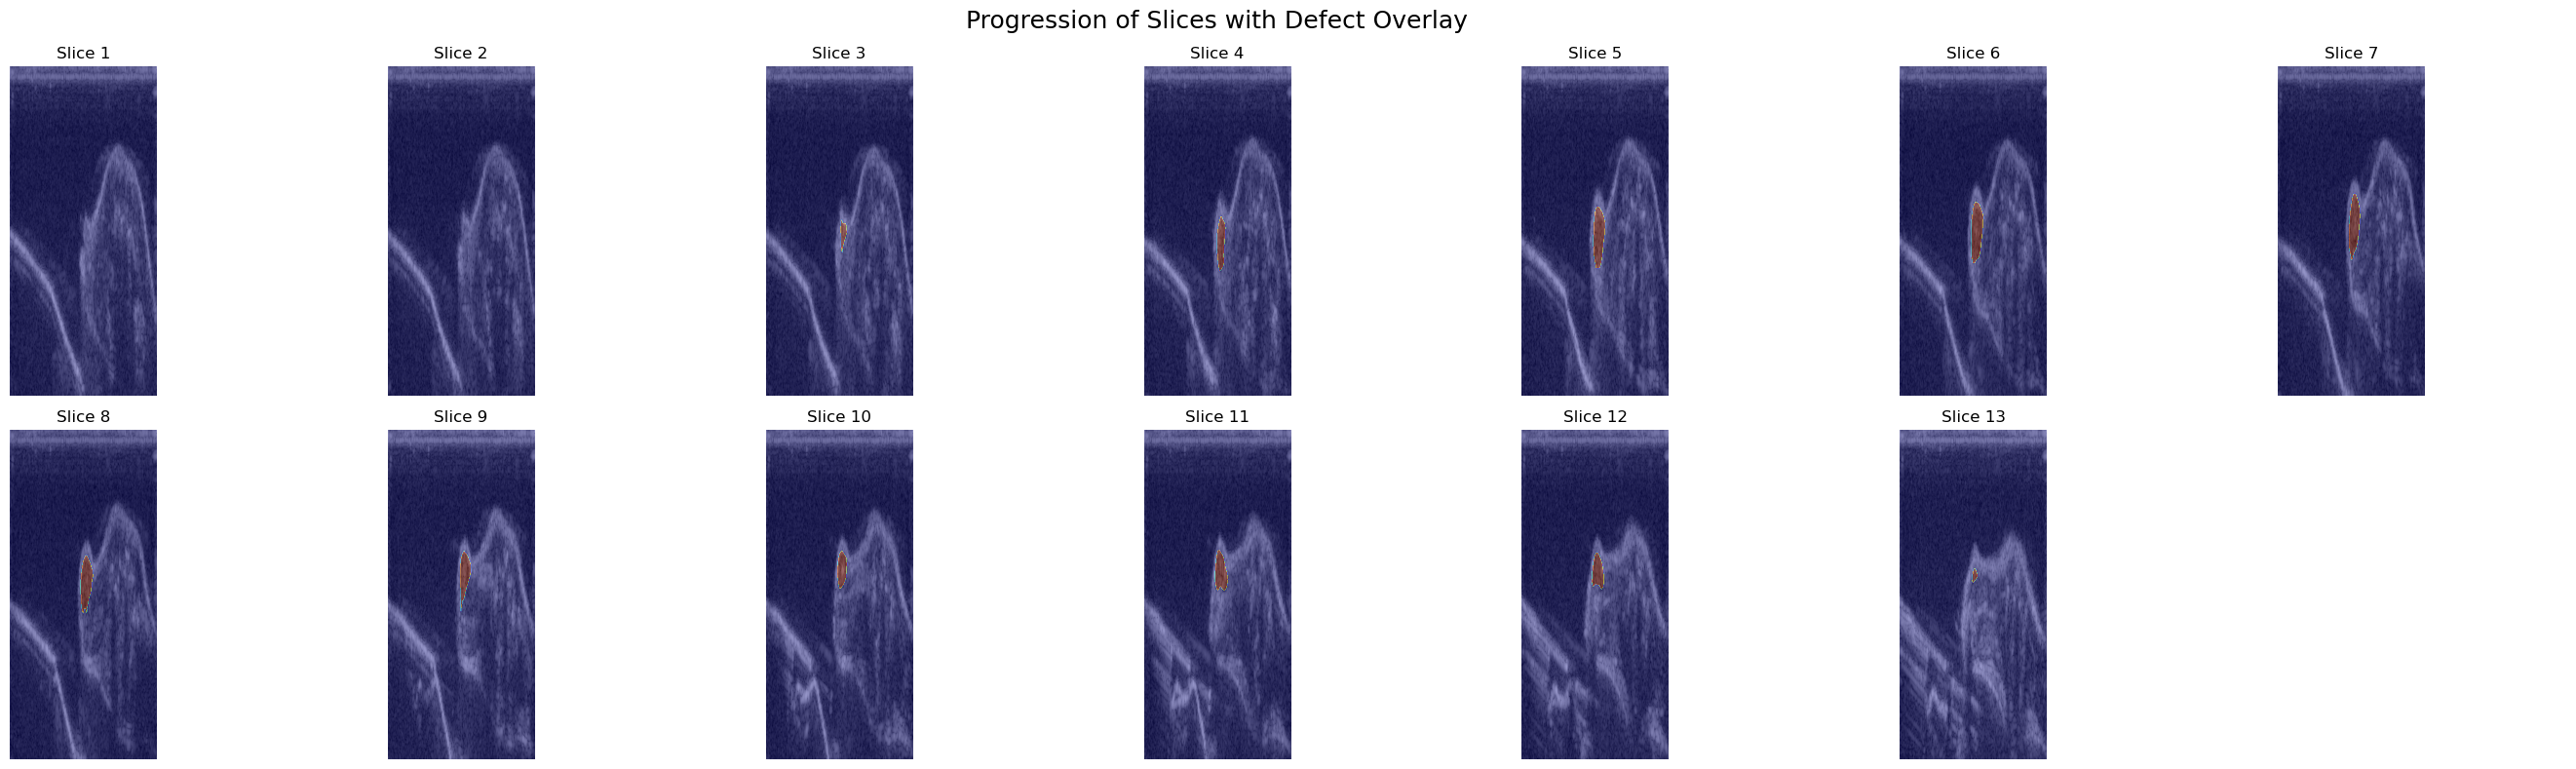

In [33]:
# Number of slices
num_slices = selected_slices.shape[0]

# Arrange slices
rows = 2
cols = (num_slices + 1) // 2  

#Visualise the slices 

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4)) 
axes = axes.flatten()  

for i in range(num_slices):
    ax = axes[i]
    ax.imshow(selected_slices[i], cmap='gray')           
    ax.imshow(selected_masks[i], cmap='jet', alpha=0.4) 
    ax.set_title(f"Slice {i+1}")
    ax.axis('off')

for j in range(num_slices, len(axes)):
    axes[j].axis('off')

plt.suptitle("Progression of Slices with Defect Overlay", fontsize=18)
plt.tight_layout()
plt.show()

## Defect Featurer Extraction

In this step, we analyze the annotated defect regions in each slice to extract key metrics.  
These metrics include:

- **Area**: Number of pixels in the defect mask  
- **Centroid**: Center of the defect region in 2D (x, y) coordinates  
- **Bounding box**: Coordinates of the rectangle enclosing the defect  
- **3D centroid**: Using the slice index as z, we get the 3D spatial location of the defect  

These metrics will be used for visualization and generating a simple inspection report.

In [36]:
# Store results in a list
metrics = []

for i, mask_slice in enumerate(selected_masks):
    # Find all pixels belonging to the defect
    defect_pixels = np.argwhere(mask_slice > 0)
    
    if defect_pixels.size == 0:
        # No defect in this slice
        metrics.append({
            "slice": i,
            "area": 0,
            "centroid_x": None,
            "centroid_y": None,
            "bbox": None
        })
        continue
    
    # Area = number of pixels
    area = defect_pixels.shape[0]
    
    # Centroid
    centroid = defect_pixels.mean(axis=0)  # returns [y, x]
    
    # Bounding box [min_y, min_x, max_y, max_x]
    min_y, min_x = defect_pixels.min(axis=0)
    max_y, max_x = defect_pixels.max(axis=0)
    bbox = (min_y, min_x, max_y, max_x)
    
    metrics.append({
        "slice": i,
        "area": area,
        "centroid_x": centroid[1],
        "centroid_y": centroid[0],
        "bbox": bbox
    })

# Convert to DataFrame for easier viewing
metrics_df = pd.DataFrame(metrics)
metrics_df

,slice,area,centroid_x,centroid_y,bbox
0,0,0,NaN,NaN,None
1,1,0,NaN,NaN,None
2,2,475,150.966316,329.174737,"(302, 146, 365, 158)"
3,3,1314,150.346271,347.338661,"(295, 143, 402, 159)"
4,4,2146,151.437558,334.006058,"(276, 141, 396, 164)"
5,5,2188,150.959324,324.454753,"(267, 141, 386, 164)"
6,6,1977,149.527061,312.195751,"(251, 140, 380, 161)"
7,7,1892,149.394820,300.732030,"(247, 139, 360, 163)"
8,8,1432,150.026536,284.695531,"(238, 142, 356, 162)"
9,9,1038,148.480732,273.851638,"(238, 140, 311, 158)"


 3D Visualization of Defects

In this step, we create a 3D scatter plot of the defect centroids across the slices.  

- **x-axis**: centroid_x (horizontal position)  
- **y-axis**: centroid_y (vertical position)  
- **z-axis**: slice index (depth)  

The **size of the points** is proportional to the defect area, giving a visual indication of how the defect grows across slices.


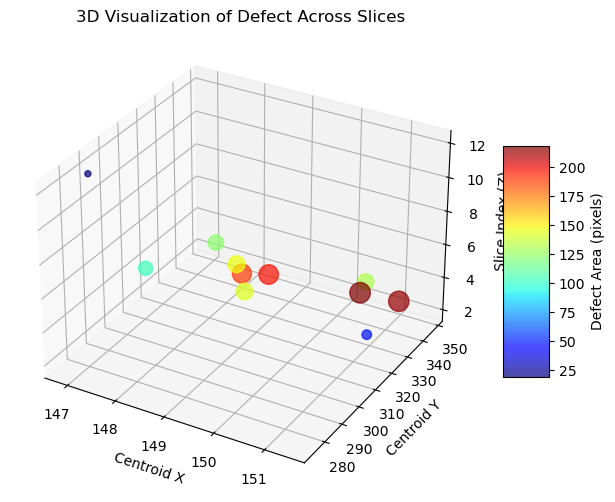

In [37]:
# Filter out slices with no defect (centroid_x = None)
valid_metrics = metrics_df.dropna(subset=['centroid_x'])

# Create 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Extract coordinates and point sizes
x = valid_metrics['centroid_x']
y = valid_metrics['centroid_y']
z = valid_metrics['slice']
sizes = valid_metrics['area'] / 10  # scale down for plotting

# Plot 3D scatter
scatter = ax.scatter(x, y, z, s=sizes, c=sizes, cmap='jet', alpha=0.7)

# Labels
ax.set_xlabel('Centroid X')
ax.set_ylabel('Centroid Y')
ax.set_zlabel('Slice Index (Z)')
ax.set_title('3D Visualization of Defect Across Slices')

# Colorbar
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Defect Area (pixels)')

plt.show()

## Interactive 3D Visualization of Defects

In [53]:
# Filter valid defects
valid_metrics = metrics_df.dropna(subset=['centroid_x'])

pv.set_jupyter_backend("trame")
plotter = pv.Plotter()

max_slice = valid_metrics['slice'].max()

for _, row in valid_metrics.iterrows():
    x = row['centroid_x']
    y = row['centroid_y']
    z = row['slice'] * 0.5  # slice spacing

    # Convert area → radius (realistic scaling)
    radius = np.sqrt(row['area'] / np.pi) / 4  # divide to keep visual scale reasonable
    radius = max(radius, 1.5)  # ensure visibility

    # Create sphere
    sphere = pv.Sphere(radius=radius, center=(x, y, z))

    # Color by slice progression
    slice_ratio = row['slice'] / max_slice
    color = (slice_ratio, 0.2, 1 - slice_ratio)

    plotter.add_mesh(sphere, color=color, opacity=0.85)

    # Add slice label
    plotter.add_point_labels(
        np.array([[x, y, z]]),
        [f"Slice {int(row['slice'])}"],
        font_size=10,
        text_color="black",
        point_size=0
    )

# Reference & scale
plotter.add_axes()
plotter.add_bounding_box(color="black")

plotter.show()

Widget(value='<iframe src="http://localhost:63469/index.html?ui=P_0x339ca0eb0_20&reconnect=auto" class="pyvist…

## Generate Inspection Report

In this step, we summarize the defect analysis and include the 3D visualization.

The report includes:

- Overview of the volume analyzed  
- Number of slices inspected  
- Defect metrics per slice (area, centroid, bounding box)

In [55]:
# Create a simple textual summary
total_slices = len(selected_slices)
total_defect_slices = valid_metrics.shape[0]
max_area = valid_metrics['area'].max()
avg_area = valid_metrics['area'].mean()

report_summary = f"""
Inspection Report – 3D Ultrasound Defect Analysis
-------------------------------------------------
Volume analyzed: Cage03_BL
Number of slices inspected: {total_slices}
Slices containing defect: {total_defect_slices}
Maximum defect area (pixels): {max_area:.0f}
Average defect area (pixels): {avg_area:.1f}

Slice-wise defect metrics:
{metrics_df.to_string(index=False)}
"""

# Print report
print(report_summary)


Inspection Report – 3D Ultrasound Defect Analysis
-------------------------------------------------
Volume analyzed: Cage03_BL
Number of slices inspected: 13
Slices containing defect: 11
Maximum defect area (pixels): 2188
Average defect area (pixels): 1395.1

Slice-wise defect metrics:
 slice  area  centroid_x  centroid_y                 bbox
     0     0         NaN         NaN                 None
     1     0         NaN         NaN                 None
     2   475  150.966316  329.174737 (302, 146, 365, 158)
     3  1314  150.346271  347.338661 (295, 143, 402, 159)
     4  2146  151.437558  334.006058 (276, 141, 396, 164)
     5  2188  150.959324  324.454753 (267, 141, 386, 164)
     6  1977  149.527061  312.195751 (251, 140, 380, 161)
     7  1892  149.394820  300.732030 (247, 139, 360, 163)
     8  1432  150.026536  284.695531 (238, 142, 356, 162)
     9  1038  148.480732  273.851638 (238, 140, 311, 158)
    10  1465  150.043686  279.950853 (236, 139, 315, 164)
    11  1225  14